# Predicting ExoPlanet Discoverability based off Planetary Features 
## Phase 2: Statistical Modelling

#### Group Name: 40

#### Name(s) & ID(s) of Group Members:
Rafat Mahiuddin (s3897093)

Adrian Rebellato (s3889401)

Arthul George (S3918048)

## Table of Contents
- [Introduction](#intro)
- [Statistical Modelling](#sm)
- [Critique & Limitations](#cl)
- [Summary & Conclusions](#sc)

## Introduction <a id='intro'></a>

### Phase 1 Summary

Phase 1 required us to process our data and approach the standard required for multiple linear regression modeling. We removed unnecessary columns, calculated new columns using data inferred from previous features, found outliers and dropped rows with missing values. We are left with almost 3000 rows, with no missing or unusual data.

Our goal is to explore what factors influence planet discoverability, by creating a Multiple Linear Regression model to predict planet radius. To facilitate this, we made two assumptions at the beginning of the study: That the distribution of exoplanets is independent of their distance from Earth, and that the radius of a planet is correlated with ease of discoverability. Our exploration suggests that the latter is true. We can also assume the former is true (until proven otherwise) as it is the simplest, and most agreed upon description of our universe accepted by astrophysicists. 

In phase 1, exploration into the relationships between features revealed a strong link between orbital distance and orbital period, distance from earth and parallax, and planet mass and radius. We also discovered how the number of exoplanets per star system dropped to 1 after 2500 parsecs. This further supports our assumptions. Finally, exploring the positional relationship between exoplanets revealed to us the Kepler mission, and how it dominated our dataset.

These relationships have helped inform the pre-processing we will conduct before creating the MLR model in Phase 2.

### Report Overview

A complete and accurate overview of the contents of your Phase 2 report. Clarification: A Table of Contents is not a report overview.

### Overview of Methodology

A detailed, complete, and accurate overview of your statistical modelling methodology (which is multiple linear regression).

## Data Processing

### Module Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import patsy

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None) 

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

df = pd.read_csv('Phase2_Group40.csv')
print('Before Rename:', df.columns.to_list())

# Rename columns to be compatible with patsy
df.rename({'semi-major_axis': 'semi_major_axis', '2_stars': 'two_stars'}, axis=1, inplace=True)
print("After Rename:")
df.head()

# Remove particular variables for better study
df = df.drop(['planet_mass', 'latitude_gal', 'longitude_gal', 'mass_ratio_sys', 'radius_ratio_sys'], axis=1 )
df.head()

Before Rename: ['num_star', '2_stars', 'orbital_period', 'semi-major_axis', 'planet_radius', 'planet_mass', 'planet_eccen', 'planet_temp', 'star_temp', 'star_radius', 'star_mass', 'star_bright', 'star_age', 'latitude_gal', 'longitude_gal', 'distance', 'parallax', 'mass_ratio_sys', 'radius_ratio_sys', 'num_planet']
After Rename:


,num_star,two_stars,orbital_period,semi_major_axis,planet_radius,planet_eccen,planet_temp,star_temp,star_radius,star_mass,star_bright,star_age,distance,parallax,num_planet
0,3,0,11688.000000,12.00000,13.400,0.45,700.0,7295.0,1.49,1.65,0.752,0.020,29.7575,33.5770,1
1,2,0,14.651600,0.11340,13.900,0.00,700.0,5172.0,0.94,0.91,-0.197,5.500,12.5855,79.4274,5
2,2,0,0.736547,0.01544,1.875,0.05,1958.0,5172.0,0.94,0.91,-0.197,10.200,12.5855,79.4274,5
3,1,0,8.463000,0.06450,4.070,0.00,593.0,3700.0,0.75,0.50,-1.046,0.022,9.7221,102.8290,2
4,1,0,18.859019,0.11010,3.240,0.00,454.0,3700.0,0.75,0.50,-1.065,0.022,9.7221,102.8290,2


### One Hot Encoding

In [2]:
# Generate a copy for data modification
data_encoded = df.copy()

In [3]:
categorical_vars = [ "num_star", "two_stars", "num_planet"]

for var in categorical_vars:
    data_encoded = data_encoded.astype({var: object})

# Categorical encoding for less than 2 values
for col in data_encoded.columns:
    q = len(data_encoded[col].unique())
    if (q == 2):
        data_encoded[col] = pd.get_dummies(data_encoded[col], drop_first=True)
# For categorical features > 2 levels
data_encoded = pd.get_dummies(data_encoded)

print(f"There are {data_encoded.shape[1]} columns with the column names {data_encoded.columns.to_list()} after one hot encoding")

There are 25 columns with the column names ['two_stars', 'orbital_period', 'semi_major_axis', 'planet_radius', 'planet_eccen', 'planet_temp', 'star_temp', 'star_radius', 'star_mass', 'star_bright', 'star_age', 'distance', 'parallax', 'num_star_1', 'num_star_2', 'num_star_3', 'num_star_4', 'num_planet_1', 'num_planet_2', 'num_planet_3', 'num_planet_4', 'num_planet_5', 'num_planet_6', 'num_planet_7', 'num_planet_8'] after one hot encoding


### Data Normalisation

In [4]:
"""
Due to the nature of our dataset, all uint8 types are considered categorical.
"""
# Perform normalisation on only the float types in df_float.
df_float = data_encoded.select_dtypes(include=['float64'])
df_float.drop('planet_radius', inplace=True, axis=1)
print(df_float.columns.to_list())
# TODO: Check if RobustScaler gives out better results
df_norm = MinMaxScaler().fit_transform(df_float)

print(f"The mean of each column in the df_norm dataframe is {np.round(df_norm.mean(axis=0),3)}")

['orbital_period', 'semi_major_axis', 'planet_eccen', 'planet_temp', 'star_temp', 'star_radius', 'star_mass', 'star_bright', 'star_age', 'distance', 'parallax']
The mean of each column in the df_norm dataframe is [0.001 0.005 0.029 0.204 0.388 0.164 0.328 0.69  0.301 0.157 0.016]


In [5]:
data_encoded.loc[:, 
        ['orbital_period', 'semi_major_axis', 'planet_eccen',
         'planet_temp', 'star_temp', 'star_radius', 'star_mass', 'star_bright',
         'star_age', 'distance', 'parallax'
        ]
        ] = pd.DataFrame(df_norm, columns=[
                                            'orbital_period', 'semi_major_axis', 
                                             'planet_eccen',
                                            'planet_temp', 'star_temp',
                                            'star_radius', 'star_mass',
                                            'star_bright', 'star_age',
                                            'distance', 'parallax'
                                            ])
data_encoded.sample(3)

,two_stars,orbital_period,semi_major_axis,planet_radius,planet_eccen,planet_temp,star_temp,star_radius,star_mass,star_bright,star_age,distance,parallax,num_star_1,num_star_2,num_star_3,num_star_4,num_planet_1,num_planet_2,num_planet_3,num_planet_4,num_planet_5,num_planet_6,num_planet_7,num_planet_8
1926,0,0.000183,0.002850,12.67,0.14086,0.222930,0.448580,0.217806,0.412639,0.761465,0.285714,0.272169,0.003088,1,0,0,0,1,0,0,0,0,0,0,0
250,0,0.000099,0.001734,2.15,0.00000,0.193885,0.404261,0.143084,0.334572,0.683949,0.029571,0.004267,0.147200,1,0,0,0,0,1,0,0,0,0,0,0
646,0,0.000194,0.002885,1.62,0.00000,0.172484,0.439637,0.166932,0.360595,0.814168,0.259286,0.390847,0.002271,1,0,0,0,1,0,0,0,0,0,0,0


## Statistical Modelling <a id='sm'></a>

### Model Overview

Overview of full model, including the variables and terms you are using in your regression model.

### Model Fitting

Details of assumptions check, model selection, plots of residuals, and technical analysis of regression results.

**NOTE:** The second half of [this](https://github.com/vaksakalli/stats_tutorials/blob/master/Regression_Case_Study1_web.ipynb) regression case study ("Statistical Modeling and Performance Evaluation" Section) will be **very helpful** for this Model Fitting section.

#### Feature Selection

##### Formula String

In [6]:
formula_string_indep_vars_encoded = ' + '.join(data_encoded.drop(columns='planet_radius').columns)
formula_string_encoded = 'planet_radius ~ ' + formula_string_indep_vars_encoded
print('formula_string_encoded: ', formula_string_encoded)

formula_string_encoded:  planet_radius ~ two_stars + orbital_period + semi_major_axis + planet_eccen + planet_temp + star_temp + star_radius + star_mass + star_bright + star_age + distance + parallax + num_star_1 + num_star_2 + num_star_3 + num_star_4 + num_planet_1 + num_planet_2 + num_planet_3 + num_planet_4 + num_planet_5 + num_planet_6 + num_planet_7 + num_planet_8


OLS model to encoded data

In [19]:
model_full = sm.formula.ols(formula=formula_string_encoded, data=data_encoded)

model_full_fitted = model_full.fit()

print(model_full_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:          planet_radius   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     97.92
Date:                Thu, 21 Oct 2021   Prob (F-statistic):               0.00
Time:                        16:32:50   Log-Likelihood:                -7750.8
No. Observations:                2895   AIC:                         1.555e+04
Df Residuals:                    2872   BIC:                         1.568e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.9042      0.960     

Visualizing the accuracy of our model by plotting actual radius vs. predicted radius

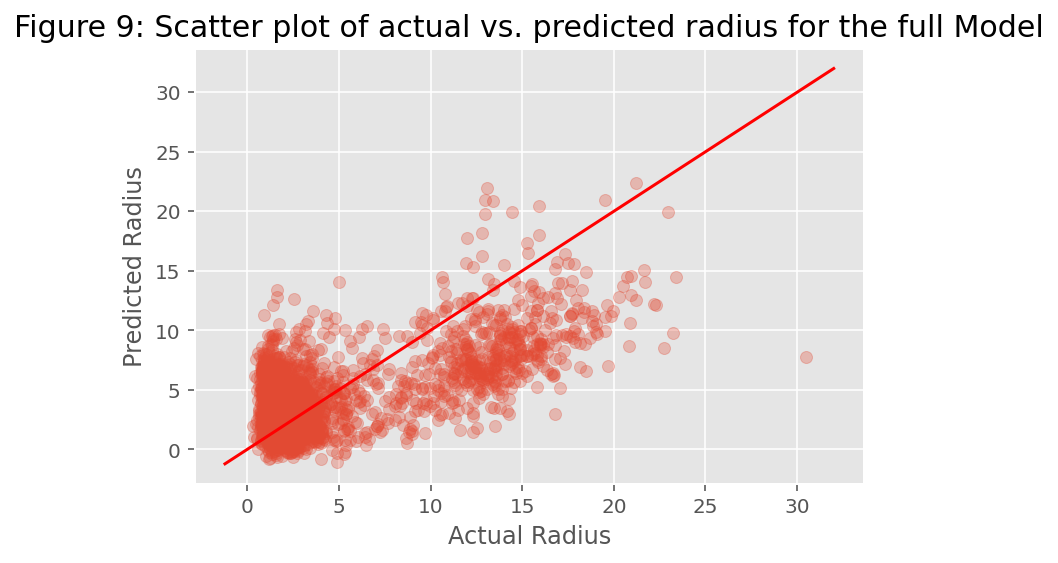

In [12]:
residuals_full = pd.DataFrame({'actual': df['planet_radius'], 
                            'predicted': model_full_fitted.fittedvalues, 
                            'residual': model_full_fitted.resid})

def plot_line(axis, slope, intercept, **kargs):
    xmin, xmax = axis.get_xlim()
    plt.plot([xmin, xmax], [xmin*slope+intercept, xmax*slope+intercept], **kargs)

plt.scatter(residuals_full['actual'], residuals_full['predicted'], alpha=0.3);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('Actual Radius');
plt.ylabel('Predicted Radius');
plt.title('Figure 9: Scatter plot of actual vs. predicted radius for the full Model', fontsize=15);
plt.show();

#### Diagnostics Check

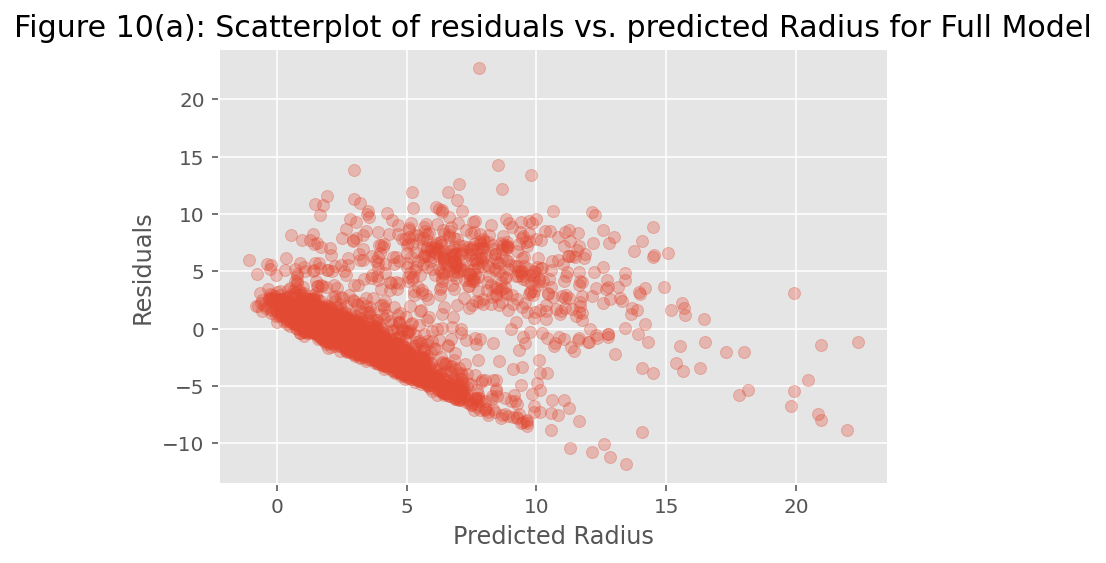

In [18]:
plt.scatter(residuals_full['predicted'], residuals_full['residual'], alpha=0.3);
plt.xlabel('Predicted Radius');
plt.ylabel('Residuals')
plt.title('Figure 10(a): Scatterplot of residuals vs. predicted Radius for Full Model', fontsize=15)
plt.show();

From this plot we see that the residuals exhibit a banding pattern, especially when Predicted Radius is below 10. The impact of the Keplar mission (as explored in Phase 1) can also be seen in this plot. The majority of datapoints which make up the left most hotspot seem to be over-estimated. Based on our previous exploration, we can assume that these data points are from the Keplar mission, which had higher success finding smaller, Earth-like exoplanets. 

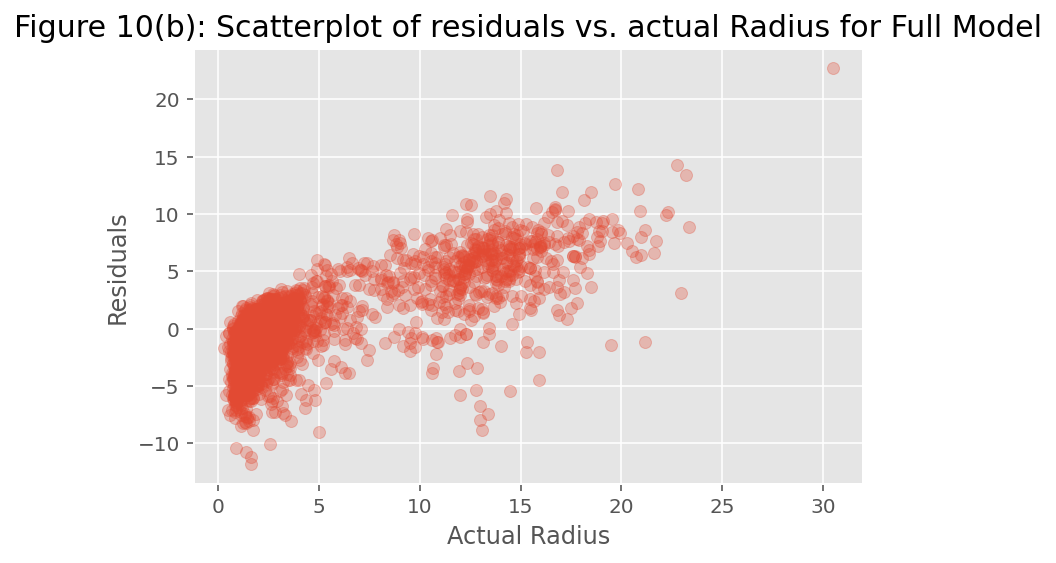

In [20]:
plt.scatter(residuals_full['actual'], residuals_full['residual'], alpha=0.3);
plt.xlabel('Actual Radius');
plt.ylabel('Residuals')
plt.title('Figure 10(b): Scatterplot of residuals vs. actual Radius for Full Model', fontsize=15)
plt.show();

The shape of this plot shows that the model over-estimates the radius of small exoplanets.

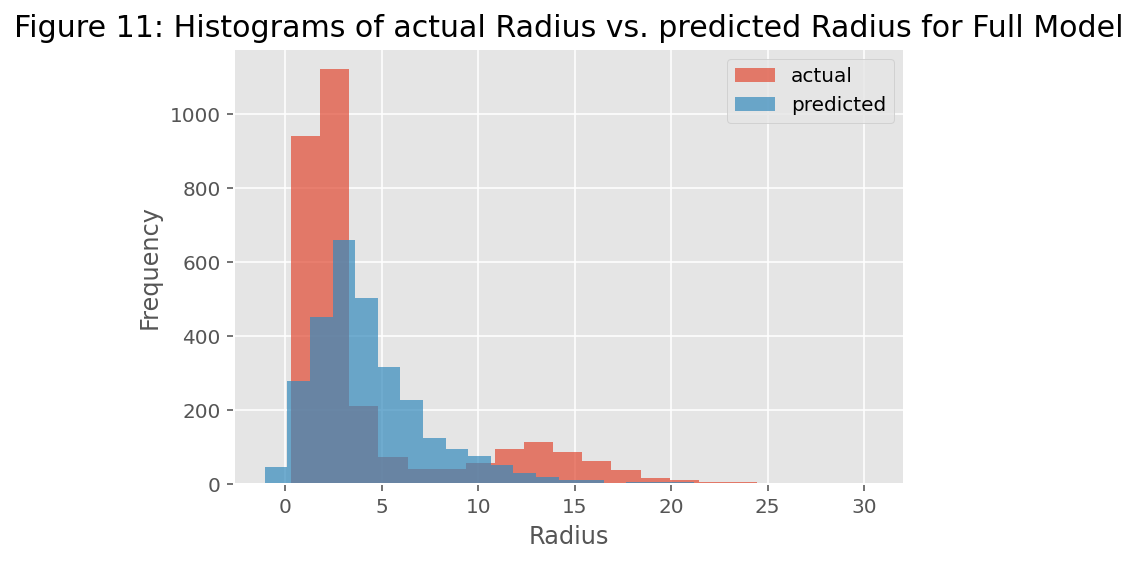

In [21]:
plt.hist(residuals_full['actual'], label='actual', bins=20, alpha=0.7);
plt.hist(residuals_full['predicted'], label='predicted', bins=20, alpha=0.7);
plt.xlabel('Radius');
plt.ylabel('Frequency');
plt.title('Figure 11: Histograms of actual Radius vs. predicted Radius for Full Model', fontsize=15);
plt.legend()
plt.show();

Visible in this histogram is how our original dataset has two peaks, one from Keplar, and the right most peak from all other missions. Our model seems to pick the middle ground, which causes significant inaccuracy.

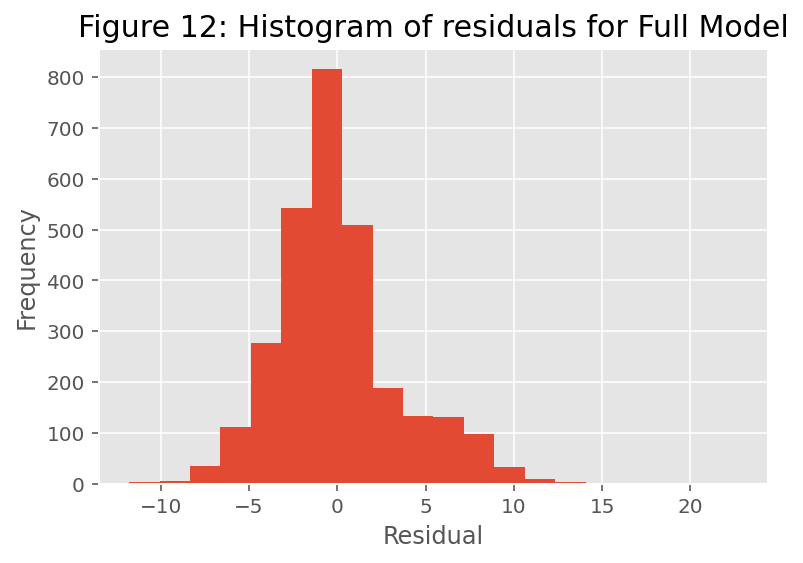

In [22]:
plt.hist(residuals_full['residual'], bins = 20);
plt.xlabel('Residual');
plt.ylabel('Frequency');
plt.title('Figure 12: Histogram of residuals for Full Model', fontsize=15);
plt.show();

Performing backwards feature selection ([credit](https://github.com/vaksakalli/stats_tutorials/blob/master/Regression_Case_Study1_web.ipynb)).

In [8]:
## create the patsy model description from formula
patsy_description = patsy.ModelDesc.from_formula(formula_string_encoded)

# initialize feature-selected fit to full model
linreg_fit = model_full_fitted

# do backwards elimination using p-values
p_val_cutoff = 0.05

## WARNING 1: The code below assumes that the Intercept term is present in the model.
## WARNING 2: It will work only with main effects and two-way interactions, if any.

print('\nPerforming backwards feature selection using p-values:')

while True:

    # uncomment the line below if you would like to see the regression summary
    # in each step:
    # print(linreg_fit.summary())

    pval_series = linreg_fit.pvalues.drop(labels='Intercept')
    pval_series = pval_series.sort_values(ascending=False)
    term = pval_series.index[0]
    pval = pval_series[0]
    if (pval < p_val_cutoff):
        break
    term_components = term.split(':')
    print(f'\nRemoving term "{term}" with p-value {pval:.4}')
    if (len(term_components) == 1): ## this is a main effect term
        patsy_description.rhs_termlist.remove(patsy.Term([patsy.EvalFactor(term_components[0])]))    
    else: ## this is an interaction term
        patsy_description.rhs_termlist.remove(patsy.Term([patsy.EvalFactor(term_components[0]), 
                                                        patsy.EvalFactor(term_components[1])]))    
        
    linreg_fit = smf.ols(formula=patsy_description, data=data_encoded).fit()
    
###
## this is the clean fit after backwards elimination
model_reduced_fitted = smf.ols(formula=patsy_description, data=data_encoded).fit()
###
    
#########
print("\n***")
print(model_reduced_fitted.summary())
print("***")
print(f"Regression number of terms: {len(model_reduced_fitted.model.exog_names)}")
print(f"Regression F-distribution p-value: {model_reduced_fitted.f_pvalue:.4f}")
print(f"Regression R-squared: {model_reduced_fitted.rsquared:.4f}")
print(f"Regression Adjusted R-squared: {model_reduced_fitted.rsquared_adj:.4f}")


Performing backwards feature selection using p-values:

Removing term "num_star_4" with p-value 0.9675

Removing term "num_star_3" with p-value 0.8402

Removing term "num_planet_2" with p-value 0.9379

Removing term "parallax" with p-value 0.6551

Removing term "num_planet_3" with p-value 0.6294

Removing term "num_star_2" with p-value 0.4447

Removing term "num_planet_7" with p-value 0.405

Removing term "num_planet_5" with p-value 0.3469

Removing term "num_planet_8" with p-value 0.2432

Removing term "two_stars" with p-value 0.2138

Removing term "num_planet_6" with p-value 0.07032

***
                            OLS Regression Results                            
Dep. Variable:          planet_radius   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     165.1
Date:                Thu, 21 Oct 2021   Prob (F-statistic):               0.00
Time:  

#### Calculating Residuals for model visualization

In [14]:
residuals_reduced = pd.DataFrame({'actual': df['planet_radius'], 
                            'predicted': model_reduced_fitted.fittedvalues, 
                            'residual': model_reduced_fitted.resid})

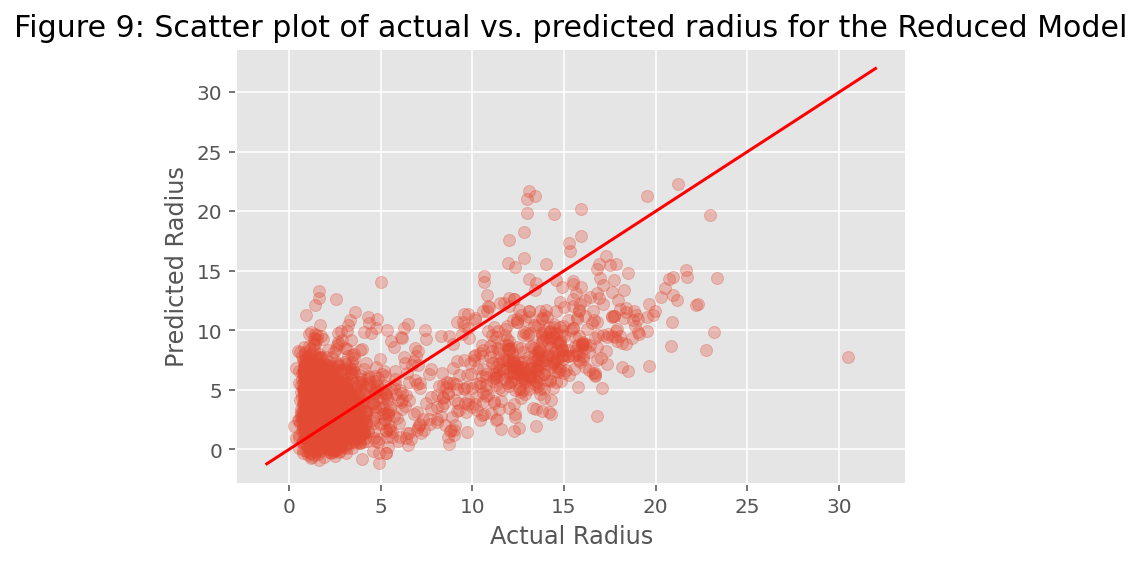

In [15]:
# Creating scatter plot for reduced model
plt.scatter(residuals_reduced['actual'], residuals_reduced['predicted'], alpha=0.3);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('Actual Radius');
plt.ylabel('Predicted Radius');
plt.title('Figure 9: Scatter plot of actual vs. predicted radius for the Reduced Model', fontsize=15);
plt.show();



## Critique & Limitations <a id='cl'></a>

Critique & Limitations of your approach: strengths and weaknesses in detail.

## Summary & Conclusions <a id='sc'></a>

### Project Summary

A comprehensive summary of your entire project (both Phase 1 and Phase 2). That is, what exactly did you do in your project? (Example: I first cleaned the data in such and such ways. And then I applied multiple linear regression techniques in such and such ways. etc).

### Summary of Findings

A comprehensive summary of your findings. That is, what exactly did you find about your particular problem?

### Conclusions

Your detailed conclusions as they relate to your goals and objectives.